### Stock Prediction - Stacked LSTM Model

In [1]:
# Ignore future warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

#import packages
import pandas as pd
import numpy as np
import os
import datetime
import pandas_datareader.data as web
from sklearn.linear_model import LinearRegression
from sklearn import metrics

#to plot within notebook
import matplotlib.pyplot as plt

In [2]:
# Data Start and end date
start = datetime.datetime(2000, 1, 1)
end = datetime.datetime(2020, 12, 10)

In [3]:
# Get data from yahoo portal
jpm_df = web.DataReader("JPM", 'yahoo',start, end)

# Sample results
jpm_df.head(3)

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2000-01-03,50.250000,48.083332,49.833332,48.583332,12019200.0,26.016140
2000-01-04,47.458332,46.125000,47.083332,47.250000,11723400.0,25.445301
2000-01-05,48.375000,46.000000,46.833332,46.958332,8714550.0,25.288227


In [4]:
# Copy main stock df
df = jpm_df.copy()

In [5]:
# Get Stock close price and index
df1=df.reset_index()['Close']

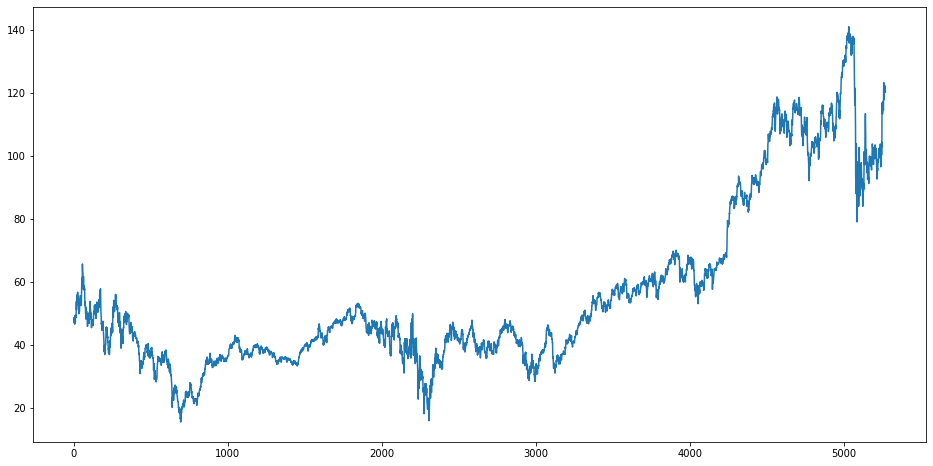

In [6]:
# Plot the data

# Set plot figure size
plt.figure(figsize=(16,8))

plt.plot(df1)
plt.show()

In [7]:
# LSTM are sensitive to the scale of the data. so we apply MinMax scaler 
from sklearn.preprocessing import MinMaxScaler

# Scale data
scaler=MinMaxScaler(feature_range=(0,1))

# Fit and transform
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [8]:
# Split dataset into train and test split - need to be % and CANNOT be random
training_size=int(len(df1)*0.70)
test_size=len(df1)-training_size
train_data,test_data=df1[0:training_size,:],df1[training_size:len(df1),:1]

In [9]:
# Check train and test data size
training_size,test_size

(3688, 1582)

In [10]:
# This function will create 100 features for each row of data

# Convert an array of values into a dataset matrix - with provided timestep
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step):
        a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100 
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [11]:
# Reshape into X=t,t+1,t+2,t+3 and Y=t+4
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [12]:
# Check train and test data shape. It is 100 less due to forward time step 
print(X_train.shape), print(y_train.shape),print(X_test.shape), print(ytest.shape)

(3588, 100)
(3588,)
(1482, 100)
(1482,)


(None, None, None, None)

In [13]:
# print(X_test.shape), print(ytest.shape)
# (340, 100)
# (340,)

In [14]:
# reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [15]:
# Create the Stacked LSTM model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [16]:
# Build Model and compile
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100, 50)           10400     
_________________________________________________________________
lstm_1 (LSTM)                (None, 100, 50)           20200     
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [18]:
# Fit data to model
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=10,batch_size=64,verbose=1)

Epoch 1/10
57/57 [==============================] - 28s 491ms/step - loss: 0.0030 - val_loss: 0.0044
Epoch 2/10
57/57 [==============================] - 22s 391ms/step - loss: 3.5929e-04 - val_loss: 0.0030
Epoch 3/10
57/57 [==============================] - 24s 413ms/step - loss: 3.3215e-04 - val_loss: 0.0022
Epoch 4/10
57/57 [==============================] - 24s 414ms/step - loss: 3.1344e-04 - val_loss: 0.0012
Epoch 5/10
57/57 [==============================] - 24s 429ms/step - loss: 3.1618e-04 - val_loss: 0.0011
Epoch 6/10
57/57 [==============================] - 24s 416ms/step - loss: 2.7562e-04 - val_loss: 9.2546e-04
Epoch 7/10
57/57 [==============================] - 25s 430ms/step - loss: 2.7209e-04 - val_loss: 9.0696e-04
Epoch 8/10
57/57 [==============================] - 24s 419ms/step - loss: 2.5701e-04 - val_loss: 7.5023e-04
Epoch 9/10
57/57 [==============================] - 25s 431ms/step - loss: 2.4356e-04 - val_loss: 6.8693e-04
Epoch 10/10
57/57 [========================

In [19]:
# Lets do the prediction and check performance metrics
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

In [20]:
# Transformback to original form
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

In [21]:
# Calculate RMSE performance metrics
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train,train_predict))

40.50821243045156

In [22]:
# Test Data RMSE
math.sqrt(mean_squared_error(ytest,test_predict))

90.36257253116158

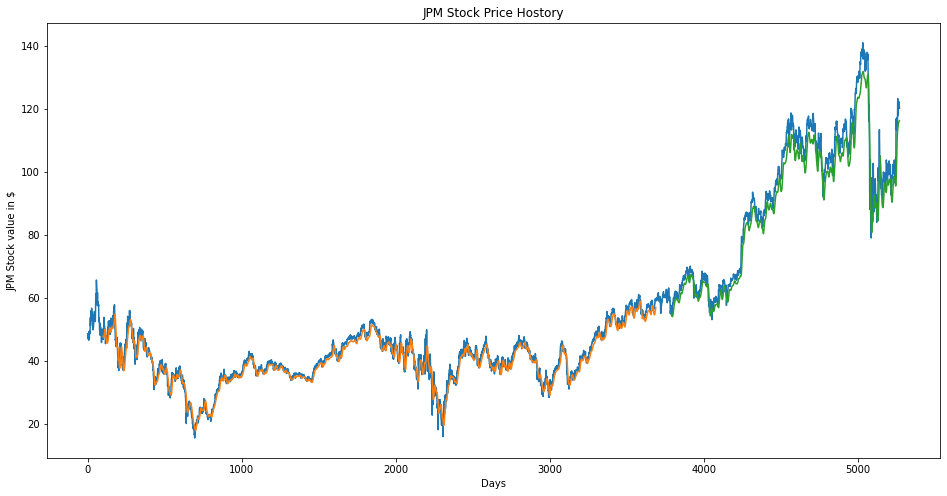

In [23]:
# Plot the data
# Set plot figure size
plt.figure(figsize=(16,8))

# Shift train predictions for plotting
look_back=100

trainPredictPlot = np.empty_like(df1)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict

# Shift test predictions for plotting
testPredictPlot = np.empty_like(df1)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2):len(df1), :] = test_predict

# Plot baseline and predictions
plt.plot(scaler.inverse_transform(df1))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)

# Labels
plt.xlabel("Days")
plt.ylabel("JPM Stock value in $")
plt.title("JPM Stock Price Hostory")
plt.show()

In [24]:
# Get input data for test data
x_input=test_data[1482:].reshape(1,-1)

# Create a temp inout from test data
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

In [25]:
# Demonstrate prediction for next 30 days
from numpy import array

lst_output=[]
n_steps = 100
i=0

while(i<30):
    
    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        #print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        #print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        #print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        #print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1

#print(lst_output)

In [26]:
# Forecast 30 days scale
day_new=np.arange(1,31)
day_pred=np.arange(1,31)

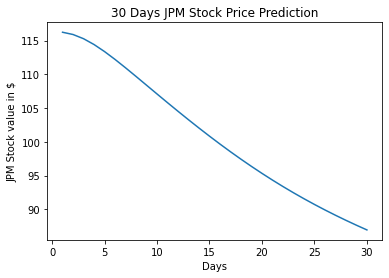

In [27]:
# 30 day stock trajectory
plt.plot(day_pred,scaler.inverse_transform(lst_output))
# Labels
plt.xlabel("Days")
plt.ylabel("JPM Stock value in $")
plt.title("30 Days JPM Stock Price Prediction")
plt.show()

In [28]:
# Create new df with forecasted data
df3=df1.tolist()
df3.extend(lst_output)
df3=scaler.inverse_transform(df3).tolist()

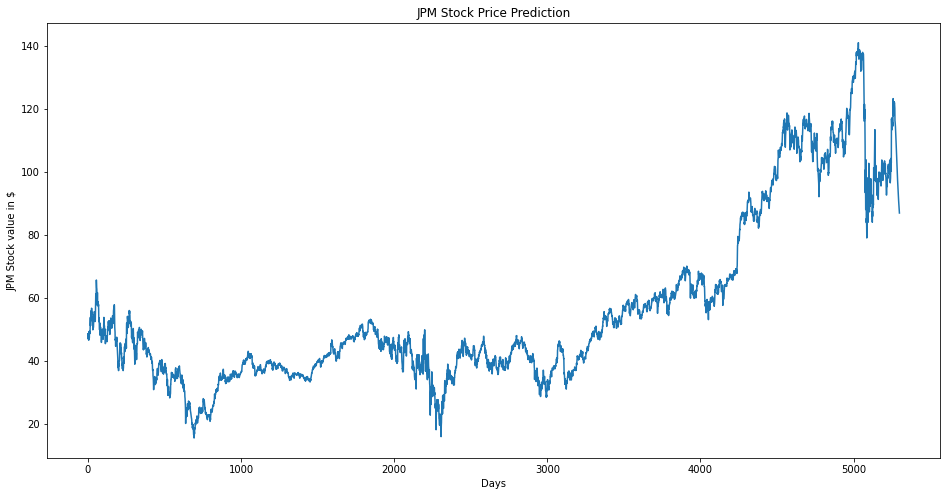

In [29]:
# Set plot figure size
plt.figure(figsize=(16,8))
plt.plot(df3)

# Labelling
plt.xlabel("Days")
plt.ylabel("JPM Stock value in $")
plt.title("JPM Stock Price Prediction")
plt.show()

In [30]:
# Get the last day stock price of 30 days forecast
df.index = (df.index - pd.to_datetime('2000-01-01')).days
X = np.asarray(df.index.values)

In [31]:
# Let's predict data for next two years or 30 days. Will need to add index range for future days 
futureindex = np.asarray(pd.RangeIndex(start=X[-1], stop=X[-1] + 30))

In [32]:
# Get last day of future stock prediction 
lastday = pd.to_datetime(futureindex[-1], origin='2000-01-01', unit='D',errors='coerce')

In [33]:
# Print the last predicted value
print (f"JPM Closing price on {str(lastday)[:10]} would be around ${round(df3[-1][0],2)}")

JPM Closing price on 2021-01-08 would be around $86.96
